In [6]:
import os
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats

import sys

from analysis import spikingResponse # custom object of trial-aligned spiking reponse
from analysis import pt, crosscorrel # plot_tools and CC-function

import matplotlib.pyplot as plt

# just to disable the HDMF cache namespace warnings, REMOVE to see them
import warnings
warnings.filterwarnings("ignore")

# 1) Loading the Optotagging results

In [7]:
#Optotagging = np.load(os.path.join('..', 'data', 'visual_coding', 'Optotagging-Results.npy'), allow_pickle=True).item()
Optotagging = np.load(os.path.join('..', 'data', 'visual_coding', 'Optotagging-Results.npy'), allow_pickle=True).item()

# randomly subsample the negative units to 100 cells per session
np.random.seed(1)
for key in ['PV','SST']:
    for n, nUnits in enumerate(Optotagging[key+'_negative_units']):
        Optotagging[key+'_negative_units'][n] = np.random.choice(nUnits, 100, replace=False)

# 2) Preprocess the stimulus-evoked spikes

In [9]:
all = True

tstart, tstop, dt = -1, 301, 1e-3
t = tstart+dt*np.arange(int((tstop-tstart)/dt))

if True:
    # turn True to re-run the analysis
    
    # load data from API
    from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
    data_directory = os.path.join(os.path.expanduser('~'), 'Downloads', 'ecephys_cache_dir')
    manifest_path = os.path.join(data_directory, "manifest.json")
    cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
    sessions = cache.get_session_table()
    
    for key in ['PV', 'SST']:
        # loop over session

        for sessionID, positive_units, negative_units in zip(Optotagging[key+'_sessions'],
                                                             Optotagging[key+'_positive_units'],
                                                             Optotagging[key+'_negative_units']):
            if all:
                units  = np.concatenate([positive_units, negative_units])
            else:
                units = positive_units
            
            session = cache.get_session_data(sessionID)
            # stimulus infos for that session
            stim_table = session.get_stimulus_table()
            # fetch summary statistics 
            analysis_metrics = cache.get_unit_analysis_metrics_by_session_type(session.session_type)
            
            for protocol in ['natural_movie_one_more_repeats',
                             'natural_movie_two',
                             #'natural_movie_three',
                             'natural_movie_one']:
                if protocol in np.unique(stim_table.stimulus_name):
                    cond = (stim_table.stimulus_name==protocol)
                    # get the number of repeats
                    blocks = np.unique(stim_table[cond].stimulus_block)
                    print(sessionID, protocol, 'n=%i blocks' % len(blocks))
                    for unit in units:
                        spike_matrix = np.zeros((len(blocks),len(t)), dtype=bool)
                        # get the spikes of that unit
                        spike_times = session.spike_times[unit]
                        # then just iterate over stimulus block:
                        for trial_idx, b in enumerate(blocks):
                            bCond = cond & (stim_table.stimulus_block==b)
                            trial_start = np.min(stim_table[bCond].start_time)
                            #tstop = np.max(stim_table[bCond].stop_time)
                            in_range = (spike_times > (trial_start + t[0])) * \
                                       (spike_times < (trial_start + t[-1]))
                            binned_times = ((spike_times[in_range] -\
                                             (trial_start + t[0])) / dt).astype('int')
                            spike_matrix[trial_idx, binned_times] = True      
                        Data = {'time_resolution':dt, 
                                'spike_matrix':spike_matrix,
                                't':t, 'keys':['t', 'spike_matrix']}
                        np.save(os.path.join('..', 'data', 'visual_coding', key,
                                             '%s_unit_%i.npy' % (protocol, unit)),
                                Data)

721123822 natural_movie_one n=2 blocks
746083955 natural_movie_one n=2 blocks
760345702 natural_movie_one n=2 blocks
773418906 natural_movie_one n=2 blocks
797828357 natural_movie_one n=2 blocks
829720705 natural_movie_one_more_repeats n=2 blocks
839557629 natural_movie_one_more_repeats n=2 blocks
840012044 natural_movie_one_more_repeats n=2 blocks
715093703 natural_movie_one n=2 blocks
719161530 natural_movie_one n=2 blocks
756029989 natural_movie_one n=2 blocks
758798717 natural_movie_one n=2 blocks
760693773 natural_movie_one n=2 blocks
762602078 natural_movie_one n=2 blocks
786091066 natural_movie_one_more_repeats n=2 blocks
787025148 natural_movie_one_more_repeats n=2 blocks
789848216 natural_movie_one_more_repeats n=2 blocks
794812542 natural_movie_one_more_repeats n=2 blocks
831882777 natural_movie_one_more_repeats n=2 blocks
839068429 natural_movie_one_more_repeats n=2 blocks


# 2) Compute the PSTH

In [10]:
# loop over frames to build the time course
RATES = {}
for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
    RATES[key+'_posUnits'] = []
    RATES[key+'_negUnits'] = []
    for sessionID in range(len(Optotagging[key+'_sessions'])):
        for u, rates, units, c in zip(range(2), [RATES[key+'_posUnits'], RATES[key+'_negUnits']],
                               [Optotagging[key+'_positive_units'][sessionID], Optotagging[key+'_negative_units'][sessionID]],
                               [color, 'tab:grey']):
            for unit in units:
                for protocol in ['natural_movie_one', 'natural_movie_one_more_repeats']:
                    filename = os.path.join('..', 'data', 'visual_coding', key, 
                                            '%s_unit_%i.npy' % (protocol, unit))
                    if os.path.isfile(filename):
                        spikeResp = spikingResponse(None, None, None, filename=filename)
                        rates.append(spikeResp.get_rate(smoothing=5e-3))
RATES['time'] = spikeResp.t
np.save(os.path.join('..', 'data', 'visual_coding', 'RATES_natural_movie_one.npy'), RATES)

# 3) Plot

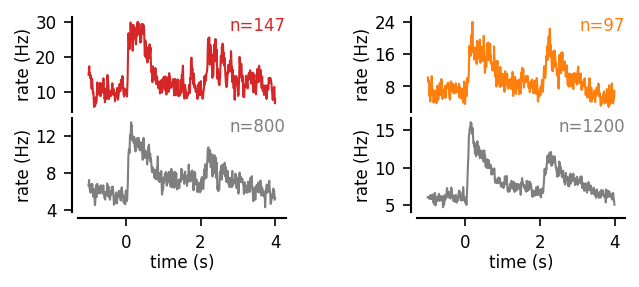

In [11]:
RATES = np.load(os.path.join('..', 'data', 'visual_coding', 'RATES_natural_movie_one.npy'),
                allow_pickle=True).item()

fig, AX = pt.figure(axes=(2,2), hspace=0.1, figsize=(1.3,1))

tCond = RATES['time']<4

for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
    for u, rates, c in zip(range(2), 
                           [RATES[key+'_posUnits'], RATES[key+'_negUnits']],
                           [color, 'tab:grey']):            
        pt.plot(RATES['time'][tCond], np.mean(rates, axis=0)[tCond],
                #sy=0.*np.std(rates, axis=0)[tCond],
                ax=AX[u][k], color=c)
        pt.annotate(AX[u][k], 'n=%i' % len(rates), (1,1), va='top', ha='right', color=c)
        pt.set_plot(AX[u][k], ['left','bottom'] if u else ['left'], 
                    ylabel='rate (Hz)', xlabel='time (s)' if u else '')


Text(0.5, 0.98, 'cross-correl. "-" vs "+" units')

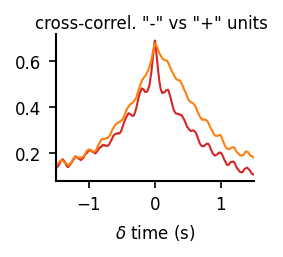

In [13]:
fig, ax = plt.subplots(1) # pt.figure()
ax.set_xlabel('$\delta$ time (s)')
CCF, time_shift = crosscorrel(np.mean(RATES['PV_negUnits'], axis=0),
                              np.mean(RATES['PV_posUnits'], axis=0),
                              1.5, RATES['time'][1]-RATES['time'][0])
ax.plot(time_shift, CCF, color='tab:red')

CCF, time_shift = crosscorrel(np.mean(RATES['SST_negUnits'], axis=0),
                              np.mean(RATES['SST_posUnits'], axis=0),
                              1.5, RATES['time'][1]-RATES['time'][0])
#ax2 = ax.twinx()
ax.plot(time_shift, CCF, color='tab:orange')
ax.set_xlim([-1.5,1.5])
fig.suptitle('cross-correl. "-" vs "+" units')

## Cross-correlation per cell

In [ ]:
CCs = {}
for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
    popRate = np.mean(RATES['%s_negUnits' % key], axis=0)
    CCs[key+'_negUnits'] = []
    for u, c in zip(['pos', 'neg'], [color, 'tab:grey']):
        for rate in RATES['%s_negUnits' % key]:
            CCF, time_shift = crosscorrel(popRate, rate,
                                          1.5, RATES['time'][1]-RATES['time'][0])
            CCs[key+'_negUnits'].append(CCF)
    CCs[key+'_posUnits'] = crosscorrel(popRate, popRate,
                                       1.5, RATES['time'][1]-RATES['time'][0])[0]
CCs['time_shift'] = time_shift
np.save(os.path.join('..', 'data', 'visual_coding', 'CC_natural_movie_one.npy'), CCs)

In [ ]:
CCs = np.load(os.path.join('..', 'data', 'visual_coding', 'CC_natural_movie_one.npy'),
              allow_pickle=True).item()

fig, ax = plt.subplots(1)
ax2 = ax.twinx()

for k, key, color in zip(range(2), ['PV', 'SST'], ['tab:red','tab:orange']):
    pt.plot(CCs['time_shift'], np.mean(CCs[key+'_negUnits'], axis=0), 
            sy=stats.sem(CCs[key+'_negUnits'], axis=0), color=color, ax=ax)
    pt.plot(CCs['time_shift'], CCs[key+'_posUnits'], 
            color='tab:grey', lw=0.5, ax=ax2)

pt.set_plot(ax, xlabel='$\delta$ time (s)', xlim=[-1.5,1.5])
fig.suptitle('cross-correl. "-" vs "+" units')